# Preâmbulo



In [1]:
!wget https://www.dropbox.com/s/89xxqp80qhb550l/macmorpho.zip
!unzip macmorpho.zip

!pip install unidecode
!pip install torchtext==0.6

--2021-03-16 00:15:45--  https://www.dropbox.com/s/89xxqp80qhb550l/macmorpho.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/89xxqp80qhb550l/macmorpho.zip [following]
--2021-03-16 00:15:45--  https://www.dropbox.com/s/raw/89xxqp80qhb550l/macmorpho.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb6657df5ec4b9a0572f80e9fd6.dl.dropboxusercontent.com/cd/0/inline/BKyXn-FeycFqonW8nf58x3cbXAvyEWA6XAtBLYZp6dcgVqiKX8yWKpvvA1qhf1IKjYOgoTNpcajC9GCpQXegF0SGMHIIJYuYWHJ2yeheEJ17P-gdPvFI7vdmXz8QmnV2W0KsdTKAiCkvo57YLYeoWVkk/file# [following]
--2021-03-16 00:15:46--  https://ucb6657df5ec4b9a0572f80e9fd6.dl.dropboxusercontent.com/cd/0/inline/BKyXn-FeycFqonW8nf58x3cbXAvyEWA6XAtBLYZp6dcgVqiKX8yWKpvvA1qhf1IKjYOgoTNpcajC9GCpQXegF0S

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, unidecode

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchtext import data
import torchtext

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# POS Tagging

**P**art-**o**f-**S**peech tagging, ou classificação sintática de sentenças, é uma área de pesquisa cujo objetivo é rotular palavras de uma frase de acordo com a sua categoria sintática.

Em linguagens naturais se trata de um problema fortemente dependente de contexto, visto palavras de escrita e fala idênticas podem ter significados completamente diferentes. Ex:

* "*O **começo** da aula foi essencial.*" $\rightarrow$ **N**ome  
* "*Eu **começo** a trabalhar às 8:00.*" $\rightarrow$ **V**erbo

Usaremos o conjunto de dados intitulado [MAC-MORPHO](http://www.nilc.icmc.usp.br/macmorpho/#ref1), com textos jornalísticos em português, extraídos da Folha de S. Paulo. Uma amostra do MAC-MORPHO é aparesentada na imagem a seguir. Para conhecer melhor as categorias desse conjunto, consulte [o manual](http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf) construído pelos autores. <br><br>

<img width=650 src="https://www.dropbox.com/s/nesqjcl2opd7vo3/MAC-MORPHO.png?dl=1">




## Carregamento de dados

Para criar o dataset, exploramos as vantagens do pacote [Torchtext](https://torchtext.readthedocs.io/en/latest/). Como vimos anteriormente, suas ferramentas facilitam tarefas essenciais como construção de vocabulário e carregamento de sequências de tamanho variável.

Uma novidade aqui é a construção de um Dataset customizado, sem o recurso de carregamento de dados tabulares. Podemos criar uma classe que herda as característica da classe [`data.Dataset`](https://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Dataset) do torchtext, ganhando liberdade para construir nosso conjunto de dados.

Para incializar nosso conjunto, basta construir no método `__init__()` as seguintes estruturas de dados:
* `examples`: uma lista de objetos tipo `data.Example`.
  * Cada exemplo é uma tupla `([amostra, rotulo], fields)`
* `fields`: uma lista de tuplas `(str, data.Field)`

Ao final do nosso `__init__()` customizado, devemos inicializar a classe "mãe" `data.Dataset` com a lista de exemplos e os fields definidos:
```python
super().__init__(self.examples, self.fields)
```


In [3]:
class MacMorpho(data.Dataset):
    
    def __init__(self, path, fields):
        
        fields = fields
        lines = open(path).read().split('\n')
        samples, labels = [], []
        
        examples = [] 
        for line in lines[:-1]:

            sample, label = [], []
            for word_cat in line.split():
                
                word, lab = word_cat.split('_')
                word = unidecode.unidecode(word.lower())
                sample.append(word)
                
                label.append(lab.split('+')[0])
                
            samples.append(sample)
            labels.append(label)
        
            examples.append(data.Example.fromlist([' '.join(sample), ' '.join(label)], fields))
        super().__init__(examples, fields)


### Defina os fields
TEXT = data.Field(include_lengths=True)
TARGET = data.Field()

### Carregue os dados
trainset, devset, testset = MacMorpho.splits(path='.',
                                             root='.',
                                             train='macmorpho-train.txt',
                                             validation='macmorpho-test.txt',
                                             test='macmorpho-dev.txt',
                                             fields=[('text', TEXT), ('target', TARGET)]
                                             )

### Construa o vocabulário
TEXT.build_vocab(trainset, max_size=20_000)
TARGET.build_vocab(trainset)

In [4]:
for sample in testset:
  print(sample.text )
  print(sample.target)

  break

['ainda', 'em', 'dezembro', 'de', '1990', ',', 'foi', 'editada', 'a', 'famosa', '289', ',', 'que', 'modificava', 'a', 'sistematica', 'da', 'arrecadacao', 'do', 'itr', 'e', 'alterava', 'suas', 'aliquotas', '.']
['ADV', 'PREP', 'N', 'PREP', 'N', 'PU', 'V', 'PCP', 'ART', 'ADJ', 'N', 'PU', 'PRO-KS', 'V', 'ART', 'N', 'PREP', 'N', 'PREP', 'NPROP', 'KC', 'V', 'PROADJ', 'N', 'PU']


### BucketIterator

Essa classe do Torchtext funciona de forma análoga ao DataLoader do PyTorch,  porém leva em consideração a construção de **batches com sequências de comprimento variável**. Internamente ele agrega sequências de comprimento similar, **minimizando a quantidade de padding necessária**. 

Além disso, os dados já saem preparados para serem empacotados pela função ```pack_padded_sequence``` ordenados por comprimento de sequência e informando o comprimento real de cada amostra (sem padding).

> Exemplo: Para compor um tensor com 5 amostras de frases com tamanhos variáveis, a segunda dimensão é definida pela frase de maior comprimento. Amostras menores são complementadas com tokens nulos (`<pad>`). 

<img src="https://drive.google.com/uc?export=view&id=1uOf8NpztcNyV0Dq9Ch5oJoKuPnwPptqK" width="450">


Documentação: https://torchtext.readthedocs.io/en/latest/data.html?highlight=BucketIterator#torchtext.data.BucketIterator

In [5]:
### Construa o iterator (nosso loader de dados)
train_iterator = data.BucketIterator(trainset, 
                                     batch_size=32, 
                                     sort_key=lambda x: len(x.text), 
                                     sort_within_batch=True)

test_iterator = data.BucketIterator(testset, batch_size=32, sort_key=lambda x: len(x.text), sort_within_batch=True)

In [6]:
for batch in test_iterator:

    inp, tam = batch.text
    lab = batch.target
    
    print(f'Entrada (shape): {inp.shape}, comprimentos (shape): {tam.shape}')
    print(f'\nComprimentos: {tam}')
    print(f'\nRotulos (shape): {lab.shape}')

    break

Entrada (shape): torch.Size([41, 32]), comprimentos (shape): torch.Size([32])

Comprimentos: tensor([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39])

Rotulos (shape): torch.Size([41, 32])


## Padding and Packing (Preenchendo e empacotando)

O pacote de funções de rnn, ```nn.utils.rnn```, oferece meios de processar batches contendo sequências de tamanho variável. Isso é realizado através do **padding** da sequência (ex: preenchimento com zeros),  de modo que elas aparentem ter igual comprimento, porém internamente as posições preenchidas não são processadas pela RNN.

*  Vamos lembrar do nosso batch de frases com tamanhos variáveis:

<img src="https://drive.google.com/uc?export=view&id=1uOf8NpztcNyV0Dq9Ch5oJoKuPnwPptqK" width="450">


*  O empacotamento precisa receber os dados em ordem decrescente de comprimento, e internamente são criados "mini batches" com o seu batch. Dessa forma, apenas os timesteps que contém informação relevante sobre o dado são apresentadas à rede. Igualmente, somente esses timesteps impactam no backpropagation.

<img src="https://drive.google.com/uc?export=view&id=1ySh4IdDO4Iw3G8p2iSdo62MW_z4kR5fd" width="450">


Para isso basta realizar o padding das suas sequências, **preservando os comprimetos originais** em outra variável. Na prática, o forward recebe mais um parâmetro, aqui chamamos de **```tamanhos```**, referente ao comprimento de cada amostra dentro do batch **```X```**, ordenado de forma descrescente.

Tendo em mãos (1) o batch de sequências preenchidas e ordenadas, e (2) o comprimento original de cada amostra, basta realizar as seguintes operações no forward da rede:

```python
## Empacote a sequência antes de alimentar a unidade recorrente
packed_input = nn.utils.rnn.pack_padded_sequence(X, tamanhos)

## Forward recorrente
packed_output, hidden = self.rnn(packed_input, hidden )

## Desempacote a sequência para continuar o fluxo na rede.
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
```

In [ ]:
# Simulando um init 
hidden_size = 128
rnn = nn.RNN( 1, hidden_size ).to(device)

# Simulando um forward
for batch in test_iterator:

  X, tamanhos = batch.text
  print(X.size(), tamanhos.size())
  hidden = torch.zeros(1, X.size(1), hidden_size).to(device)

  ## Empacote a sequência antes de alimentar a unidade recorrente
  packed_input = nn.utils.rnn.pack_padded_sequence(X.unsqueeze(-1).float().to(device), tamanhos)
  print('\npacked_input.batch_sizes:', packed_input.batch_sizes)

  ## Forward recorrente
  packed_output, hidden = rnn(packed_input, hidden )
  print('\npacked_output.batch_sizes:', packed_output.batch_sizes)
  print('\nhidden:', hidden.size())

  ## Desempacote a sequência para continuar o fluxo na rede.
  output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
  print('\noutput:', output.size())
  
  break

torch.Size([7, 32]) torch.Size([32])

packed_input.batch_sizes: tensor([32, 32, 32, 32, 32, 32, 32])

packed_output.batch_sizes: tensor([32, 32, 32, 32, 32, 32, 32])

hidden: torch.Size([1, 32, 128])

output: torch.Size([7, 32, 128])


## Exercício

1) Vamos implementar uma RNN simples com  a seguinte arquitetura:
* [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
* [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=rnn#torch.nn.RNN)
* [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear) com ativação [`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax).

Note que se trata de um problema **muitos para muitos**, ou seja, precisamos realizar ambos o passo recorrente e a inferência com a camada linear em todos os elementos da sequência. Para tal, a camada `nn.Linear` suporta tensores de quaisquer dimensões `(N, *, H_in)`, aplicando a transformação linear apenas na última dimensão.

2) Modifique agora o seu modelo para uma **RNN bidirecional**. 
> Note que essa arquitetura na prática dobra a quantidade de pesos em relação à RNN unidirecional. Sugiro dividir pela metade o hiperparâmetro que você definiu no passo 1 para o `hidden_size` para comparar as duas redes com igual complexidade.
![](https://drive.google.com/uc?export=view&id=158b3Y_o-7yXsKMe5VdaifhPg0Du4A6dp) <br>
Na implementação, o que muda em relação à camada unidirecional é:
*  Ao instanciar a camada recorrente, defina o parâmetro **```bidirectional = True```**
*  O hidden state tem dimensionalidade **```(num_layers * 2, batch_size, hidden_size)```**
*  O output tem dimensionalidade **```(seq_len, batch_size, hidden_size * 2)```**



In [7]:
class RNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, out_size, 
                 num_layers, dropout=0.5):
        super(RNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.embed  = nn.Embedding(vocab_size, embed_size)

        self.rnn    = nn.RNN(embed_size, hidden_size,  
                              num_layers=self.num_layers)
        
        self.linear = nn.Linear(hidden_size, out_size)
        
    def forward(self, X, lengths):
        # X: S x B x D
        
        # HIDDEN: L x B x H
        hidden = torch.zeros(self.num_layers, X.size(1), self.hidden_size).to(device)
        
        embed = self.embed(X)
        # EM: S x B x E

        ## Empacote a sequência antes de alimentar a unidade recorrente
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths)
 
        ## Forward recorrente
        packed_output, hidden = self.rnn(packed_input, hidden )
        
        ## Desempacote a sequência para continuar o fluxo na rede.
        outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # OUT: S x B x H , HIDDEN: L x B x H

        output = F.log_softmax(self.linear( outputs ), dim=-1)
        # OUT: S x B x O
        
        return output
        
        
net = RNN( len(TEXT.vocab), 50, 128, len(TARGET.vocab), 2).to(device)

In [ ]:
### TODO: ARQUITETURA BIDIRECIONAL



### Definindo otimizador e função de perda

In [8]:
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.NLLLoss().to(device)

### Fluxo de Treinamento e Validação 

In [10]:
def forward(iterator, epoch, optimizer, criterion, mode):
    
    acc = 0.
    epoch_loss = []
    for sample in iterator:
        
        text, lengths = sample.text
        text = text.to(device)
        label = sample.target
        label = label.to(device)
        
        out = net(text, lengths)
        # S x B x C

        loss = criterion(out.view(out.size(0)*out.size(1), -1),
                         label.view(label.size(0)*label.size(1)))
        
        epoch_loss.append(loss.detach().cpu().item())
        
        _, pred = torch.max(out.detach(), dim=-1)
        acc += torch.sum(pred == label).item()/(pred.size(0)*pred.size(1)) 

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    epoch_loss = np.asarray(epoch_loss)
    print(f'Epoch {epoch} - Loss: {epoch_loss.mean():.4f}+/-{epoch_loss.std():.4f}, Acc: {(acc/len(iterator))*100:.2f}%')
    
    return epoch_loss.mean()
        

In [11]:
train_loss, test_loss = [], []
for epoch in range(30):
    
    loss = forward(train_iterator, epoch, optimizer, criterion, 'train')
    train_loss.append(loss)
    
    loss = forward(test_iterator, epoch, optimizer, criterion, 'test')
    test_loss.append(loss)
    
    print('--'*20)


Epoch 0 - Loss: 1.0278+/-0.3345, Acc: 68.92%
Epoch 0 - Loss: 0.7930+/-0.1693, Acc: 76.81%
----------------------------------------
Epoch 1 - Loss: 0.6485+/-0.1675, Acc: 80.20%
Epoch 1 - Loss: 0.5364+/-0.1537, Acc: 84.40%
----------------------------------------
Epoch 2 - Loss: 0.4376+/-0.1303, Acc: 87.13%
Epoch 2 - Loss: 0.3824+/-0.1300, Acc: 89.37%
----------------------------------------
Epoch 3 - Loss: 0.3425+/-0.1077, Acc: 90.13%
Epoch 3 - Loss: 0.3450+/-0.0963, Acc: 90.32%
----------------------------------------
Epoch 4 - Loss: 0.3107+/-0.0819, Acc: 90.97%
Epoch 4 - Loss: 0.3171+/-0.0878, Acc: 90.94%
----------------------------------------
Epoch 5 - Loss: 0.2969+/-0.0758, Acc: 91.27%
Epoch 5 - Loss: 0.3222+/-0.0791, Acc: 90.22%
----------------------------------------
Epoch 6 - Loss: 0.2859+/-0.0662, Acc: 91.44%
Epoch 6 - Loss: 0.3083+/-0.0789, Acc: 90.73%
----------------------------------------
Epoch 7 - Loss: 0.2791+/-0.0577, Acc: 91.50%
Epoch 7 - Loss: 0.2931+/-0.0661, Acc: 

### Predizendo instâncias

In [ ]:
def pred( sentence ):

  text  = [unidecode.unidecode(word.split('_')[0]).lower() for word in sentence.split()]
  label = [TARGET.vocab.stoi[word.split('_')[1].split('+')[0]] for word in sentence.split()]
  print(text)
  text = [TEXT.vocab.stoi[t] for t in text]

  text = torch.LongTensor(text)
  text = text.view(text.size(0), 1).to(device)
  out = net(text, torch.LongTensor( [len(text)] ))

  _, pred = torch.max(out, -1)
  print([TARGET.vocab.itos[p] for p in pred.squeeze() ],'\n') 

  return np.asarray(label), pred.detach().cpu().numpy().squeeze()

with open('macmorpho-dev.txt') as fp:
  sentences = fp.read().split('\n')
  for i in range(10):
    sentence = sentences[i]
    ytrue, ypred = pred(sentence)

['ainda', 'em', 'dezembro', 'de', '1990', ',', 'foi', 'editada', 'a', 'famosa', '289', ',', 'que', 'modificava', 'a', 'sistematica', 'da', 'arrecadacao', 'do', 'itr', 'e', 'alterava', 'suas', 'aliquotas', '.']
['PDEN', 'PREP', 'N', 'PREP', 'N', 'PU', 'V', 'PCP', 'ART', 'ADJ', 'N', 'PU', 'PRO-KS', 'V', 'ART', 'N', 'PREP', 'N', 'PREP', 'NPROP', 'KC', 'V', 'PROADJ', 'N', 'PU'] 

['porem', ',', 'como', 'a', 'previsao', 'indica', 'entrada', 'de', 'frente', 'fria', ',', 'deve', '-se', 'aguardar', 'ate', 'quarta-feira', 'e', 'irrigar', 'somente', 'se', 'o', 'total', 'de', 'chuva', 'for', 'inferior', 'a', '30', 'mm', '.']
['KC', 'PU', 'PREP', 'ART', 'N', 'V', 'N', 'PREP', 'N', 'ADJ', 'PU', 'V', 'PROPESS', 'V', 'PREP', 'N', 'KC', 'N', 'PDEN', 'KS', 'ART', 'N', 'PREP', 'N', 'V', 'ADJ', 'PREP', 'NUM', 'N', 'PU'] 

['"', 'o', 'crescimento', 'e', 'expressivo', 'mas', ',', 'mesmo', 'assim', ',', 'estamos', 'abaixo', 'da', 'media', 'historica', 'do', 'setor', ',', 'que', 'e', 'de', '45', 'mil', 'trat

### Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix

dev_iterator = data.BucketIterator(devset, batch_size=32, sort_key=lambda x: len(x.text), sort_within_batch=True)
predictions, labels = [], []
for sample in dev_iterator:
    
    text, lengths = sample.text
    label = sample.target
    
    out = net(text.to(device), lengths)
    _, pred = torch.max(out, -1)
    
    predictions.extend(list(pred.view(-1).cpu().numpy()))
    labels.extend( list(label.view(-1).numpy() )  )

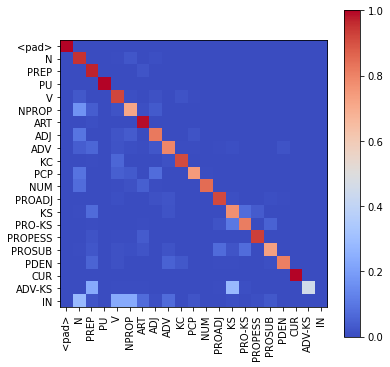

In [ ]:
conf = confusion_matrix(y_true=labels, y_pred=predictions, normalize='true')
plt.figure(figsize=(6,6))
plt.imshow(conf, cmap='coolwarm')
plt.colorbar()
plt.xticks(np.arange(0, len(TARGET.vocab)-1), TARGET.vocab.itos[1:], rotation=90)
plt.yticks(np.arange(0, len(TARGET.vocab)-1), TARGET.vocab.itos[1:])
plt.show()